# Haario-Bardenet AC

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *

import pints
import pints.plot
import pints.toy
import pints.functionaltests.haario_bardenet_acmc as hb

from utils import run_replicates, ecdf_norm_plotter

parallel = True

# Two dimensional Gaussian

In [2]:
t = pints.Timer()
test = run_replicates(np.geomspace(2000, 20000, 8), 10, hb.two_dim_gaussian, parallel)
print(t.format())

53.79 seconds


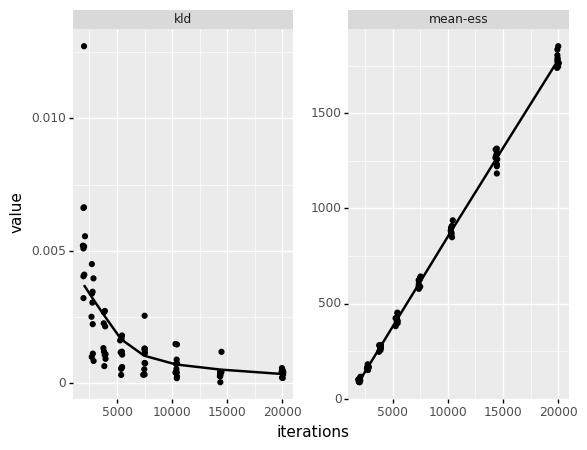

<ggplot: (8780473516282)>

In [3]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The ESS and KLD both trend in the correct directions.

Show example run results.

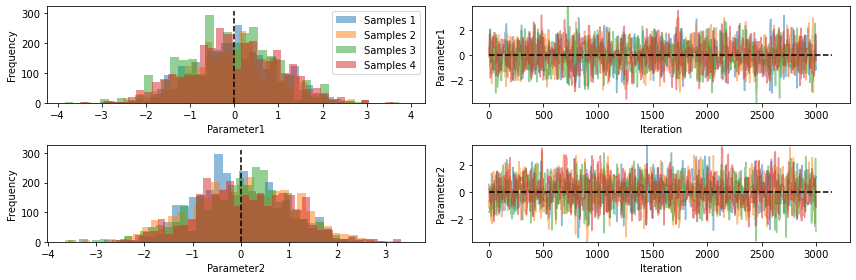

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  -0.01   1.03    -2.02   -0.68  -0.02  0.69   2.03     1.00    1190.83  570.01
param 2  0.03    1.00    -1.94   -0.65  0.04   0.74   1.86     1.00    1146.84  548.95


In [4]:
n_chains = 4
n_iterations = 4000
n_warmup = 1000
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

# Get initial parameters
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.HaarioBardenetACMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.trace(chains, ref_parameters=[0, 0])

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

The parameters are close to their true means. How do they compare to MCMC eCDFs compare with the theoretical? Look pretty good.

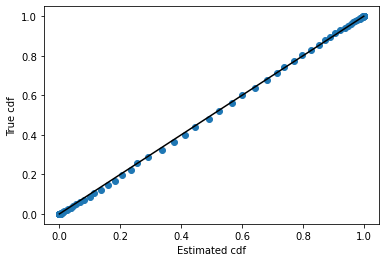

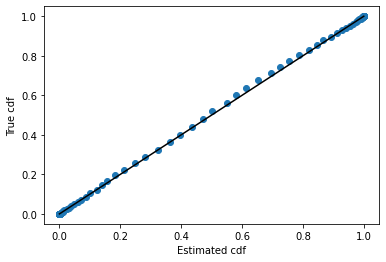

[None, None]

In [5]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], 1) for i in range(2)]

# Correlated Gaussian

In [6]:
t = pints.Timer()
test = run_replicates(np.geomspace(5000, 20000, 8), 10, hb.correlated_gaussian, parallel)
print(t.format())

1 minute, 21 seconds


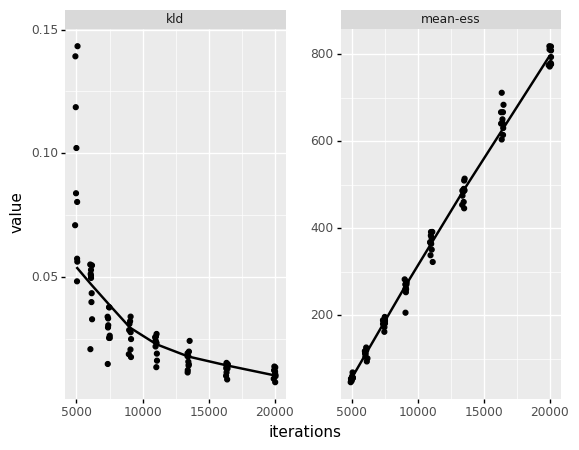

<ggplot: (8780655285580)>

In [7]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Example run of results.

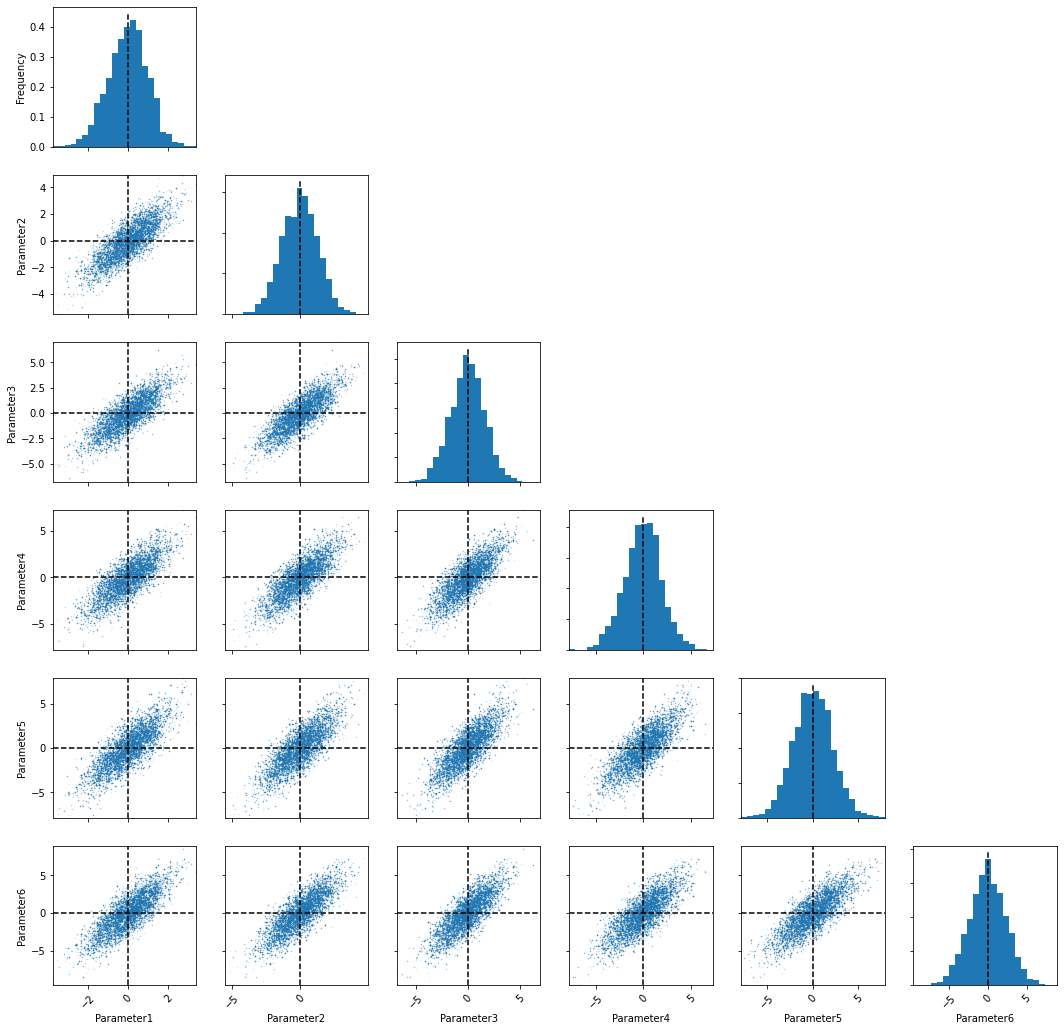

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  0.00    0.97    -1.94   -0.62  0.04   0.66   1.82     1.01    929.57  181.44
param 2  -0.05   1.34    -2.66   -0.97  -0.04  0.86   2.51     1.00    943.33  184.12
param 3  -0.06   1.64    -3.31   -1.13  -0.03  1.04   3.09     1.01    916.36  178.86
param 4  -0.06   1.93    -4.02   -1.30  -0.01  1.20   3.78     1.01    906.83  177.00
param 5  0.02    2.14    -4.14   -1.39  0.04   1.46   4.23     1.01    976.26  190.55
param 6  0.03    2.36    -4.64   -1.55  0.05   1.61   4.65     1.00    889.82  173.68


In [8]:
n_chains = 4
n_iterations = 8000
n_warmup = 4000

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.HaarioBardenetACMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Again the estimated means compare well with the theoretical. Now comparing the theoretical and empirical cdfs: again, these look fine.

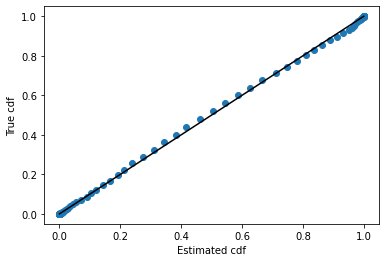

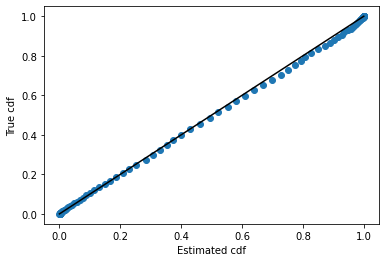

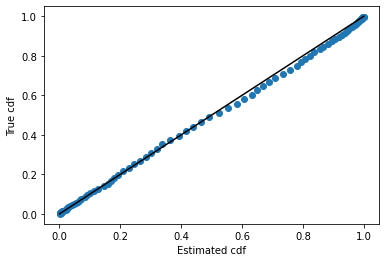

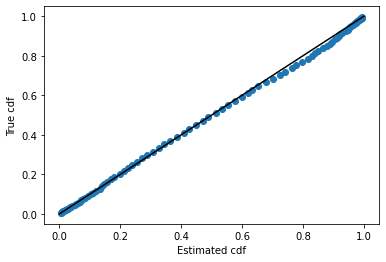

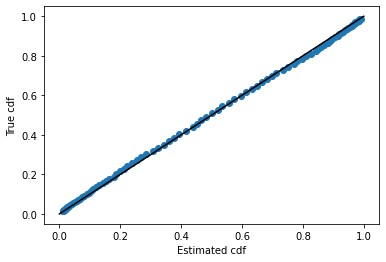

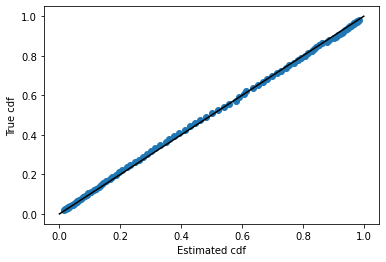

[None, None, None, None, None, None]

In [9]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], np.sqrt(i + 1)) for i in range(6)]

# Banana

In [10]:
t = pints.Timer()
test = run_replicates(np.geomspace(2000, 10000, 8), 10, hb.banana, parallel)
print(t.format())

33.33 seconds


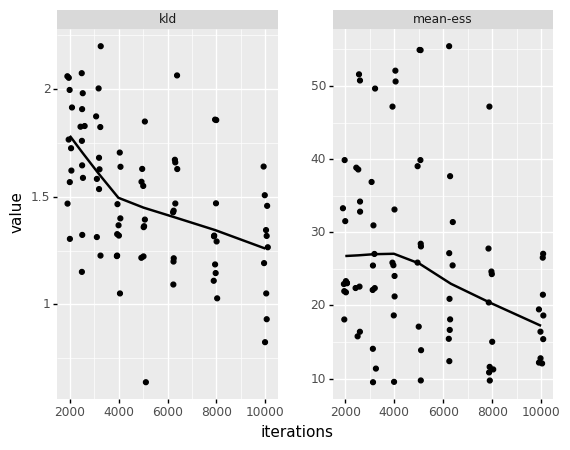

<ggplot: (8780452132901)>

In [11]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The banana is a hard problem. Because of this, both the ESS and KLD do not behave well. It's likely that this is due to the problem being too hard for Haario-Bardenet, rather than there being an issue with the method itself.

Example run of results.

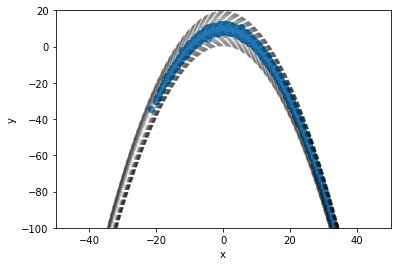

In [12]:
n_chains = 4
n_iterations = 4000
n_warmup = 1000

log_pdf = pints.toy.TwistedGaussianLogPDF(dimension=2, b=0.1)
log_prior = pints.MultivariateGaussianLogPrior([0, 0],
                                               [[10, 0], [0, 10]])
x0 = log_prior.sample(n_chains)
sigma0 = np.diag(np.array([1, 3]))

levels = np.linspace(-50, -1, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf([i, j]) for i in x] for j in y]

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.HaarioBardenetACMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlim(-50, 50)
plt.ylim(-100, 20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Annulus

In [13]:
t = pints.Timer()
test = run_replicates(np.geomspace(3000, 20000, 8), 10, hb.annulus, parallel)
print(t.format())

1 minute, 51 seconds


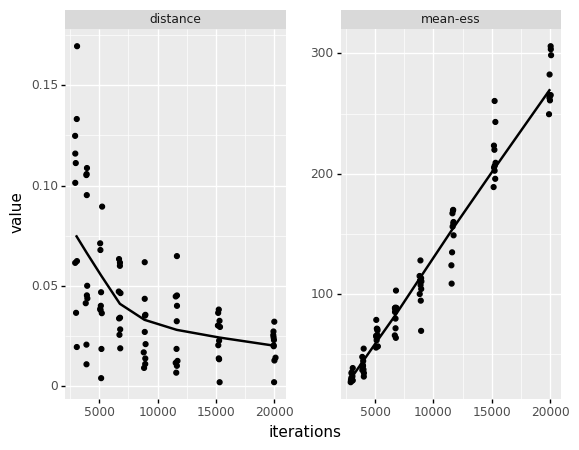

<ggplot: (8780460316453)>

In [14]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Haario-Bardenet performs ok on the annulus problem: both the KLD and ESS behave as expected.

Example run.

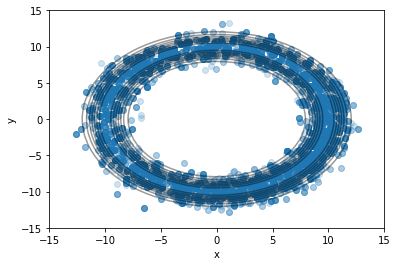

In [15]:
n_chains = 4
n_iterations = 4000
n_warmup = 2000

log_pdf = pints.toy.AnnulusLogPDF()
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.HaarioBardenetACMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.4)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()